# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_564733/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_564733/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_564733/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2026-01-09 19:20:21,635] A new study created in RDB with name: no-name-7a415ddd-7260-4f9d-929a-c987e8835c79
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<11:51,  2.81it/s]

current_loss: tensor(1.4542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4470198154449463
current_loss: tensor(1.4499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4272702932357788
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:42, 12.28it/s]

current_loss: tensor(1.4702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4170114994049072
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4157307147979736
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.415446162223816
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4154804944992065
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:02, 16.28it/s]

current_loss_val:  1.4154670238494873
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.415418028831482
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4153878688812256
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4153655767440796
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4153711795806885


  1%|          | 13/2000 [00:00<02:02, 16.18it/s]

current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4152663946151733
current_loss: tensor(1.4185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4150229692459106
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149996042251587
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<01:47, 18.48it/s]

current_loss_val:  1.4150161743164062
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4150066375732422
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149816036224365
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.414969801902771
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.415004849433899


  1%|          | 22/2000 [00:01<02:11, 15.01it/s]


current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149954319000244
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149847030639648
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149940013885498
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149720668792725
Early Stop at iteration 22 with minimal loss tensor(1.4150, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<04:06,  8.12it/s]

current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3737874031066895
current_loss: tensor(1.3817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3072624206542969


  0%|          | 3/2000 [00:00<03:50,  8.68it/s]

current_loss: tensor(1.3293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2949594259262085
current_loss: tensor(1.3161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2910230159759521


  0%|          | 5/2000 [00:00<03:29,  9.54it/s]

current_loss: tensor(1.3098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2876187562942505
current_loss: tensor(1.3066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2845838069915771
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:20,  9.94it/s]

current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2764427661895752
current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721617221832275
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:13, 10.29it/s]

current_loss_val:  1.2712786197662354
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707561254501343
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697666883468628


  1%|          | 13/2000 [00:01<03:11, 10.36it/s]

current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681236267089844
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678099870681763
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:10, 10.41it/s]

current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677013874053955
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675585746765137
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:09, 10.45it/s]

current_loss_val:  1.2669968605041504
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266849160194397
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659783363342285


  1%|          | 19/2000 [00:01<03:09, 10.48it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642849683761597
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619351148605347
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:08, 10.49it/s]

current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598673105239868
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594209909439087
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:07, 10.52it/s]

current_loss_val:  1.2589774131774902
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583309412002563
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565975189208984


  1%|▏         | 27/2000 [00:02<03:07, 10.53it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556393146514893
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553638219833374
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:06, 10.54it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25544011592865
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255553960800171
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:16, 10.01it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555623054504395
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555510997772217
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:19,  9.89it/s]


current_loss_val:  1.2555630207061768
Early Stop at iteration 31 with minimal loss tensor(1.2554, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:20:28,750] Trial 0 finished with value: -2.5107274055480957 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.57460020600884, 'penalty_decorrelation_ridge_second_difference': 5.2598516953713546}. Best is trial 0 with value: -2.5107274055480957.
  0%|          | 1/2000 [00:00<04:20,  7.66it/s]

current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554329633712769
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552757263183594


  0%|          | 3/2000 [00:00<03:27,  9.64it/s]

current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548471689224243
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544951438903809
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:17, 10.12it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535896301269531
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532793283462524
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:10, 10.43it/s]

current_loss_val:  1.253064513206482
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527520656585693
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523963451385498


  1%|          | 11/2000 [00:01<03:13, 10.30it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521212100982666
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518831491470337
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:12, 10.34it/s]

current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25166654586792
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515461444854736
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:11, 10.36it/s]

current_loss_val:  1.2519712448120117
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512056827545166
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511481046676636


  1%|          | 17/2000 [00:01<03:10, 10.40it/s]

current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510130405426025
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508010864257812
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505240440368652
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500494718551636
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:08, 10.47it/s]

current_loss_val:  1.2494776248931885
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493970394134521
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493399381637573


  1%|▏         | 25/2000 [00:02<03:08, 10.48it/s]

current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491943836212158
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490060329437256
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:08, 10.47it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490264177322388
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490419149398804
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:16, 10.01it/s]

current_loss_val:  1.2490718364715576
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491000890731812
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491084337234497
Early Stop at iteration 29 with minimal loss tensor(1.2490, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:20:32,196] Trial 1 finished with value: -2.498012065887451 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.304427118165222, 'penalty_decorrelation_ridge_second_difference': 12.721563417758087}. Best is trial 1 with value: -2.498012065887451.
  0%|          | 1/2000 [00:00<04:29,  7.43it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552372217178345
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:31,  9.45it/s]

current_loss_val:  1.2549408674240112
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533245086669922
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521713972091675


  0%|          | 5/2000 [00:00<03:20,  9.94it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523468732833862
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523763179779053
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:16, 10.17it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523642778396606
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252252221107483
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:26,  9.63it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521209716796875
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516478300094604
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:16, 10.12it/s]

current_loss_val:  1.25076425075531
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491198778152466
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247399926185608


  1%|          | 15/2000 [00:01<03:13, 10.24it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246451497077942
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463312149047852
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:11, 10.34it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246203899383545
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457512617111206
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:11, 10.36it/s]

current_loss_val:  1.2455720901489258
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455729246139526
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455726861953735


  1%|          | 21/2000 [00:02<03:09, 10.44it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455755472183228
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455940246582031


  1%|          | 22/2000 [00:02<03:26,  9.58it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456161975860596
Early Stop at iteration 22 with minimal loss tensor(1.2456, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:20:35,044] Trial 2 finished with value: -2.4911439418792725 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.0339974268325935, 'penalty_decorrelation_ridge_second_difference': 27.46328651855659}. Best is trial 2 with value: -2.4911439418792725.
  0%|          | 1/2000 [00:00<04:29,  7.42it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552812099456787
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:31,  9.45it/s]

current_loss_val:  1.2550116777420044
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538435459136963
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529287338256836


  0%|          | 5/2000 [00:00<03:22,  9.87it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523338794708252
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510874271392822
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:17, 10.10it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497215270996094
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490253448486328
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:12, 10.35it/s]

current_loss_val:  1.2489312887191772
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486881017684937
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248399257659912


  1%|          | 13/2000 [00:01<03:11, 10.39it/s]

current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482737302780151
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481530904769897
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:11, 10.37it/s]

current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481369972229004
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481091022491455
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:10, 10.39it/s]

current_loss_val:  1.2479853630065918
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247806191444397
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476270198822021


  1%|          | 19/2000 [00:01<03:10, 10.40it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471214532852173
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468692064285278
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:10, 10.40it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465267181396484
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245632529258728
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:09, 10.43it/s]

current_loss_val:  1.2447556257247925
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244458794593811
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442305088043213


  1%|▏         | 27/2000 [00:02<03:08, 10.45it/s]

current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430744171142578
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422451972961426
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:08, 10.45it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242264986038208
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422864437103271
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:17,  9.99it/s]

current_loss_val:  1.2423920631408691
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425457239151
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425694465637207
Early Stop at iteration 31 with minimal loss tensor(1.2422, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:20:38,661] Trial 3 finished with value: -2.484490156173706 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.898877826252953, 'penalty_decorrelation_ridge_second_difference': 21.629236382376103}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552591562271118
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:29,  9.54it/s]

current_loss_val:  1.254989743232727
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253580927848816
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525662183761597


  0%|          | 5/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527127265930176
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527332305908203
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:13, 10.31it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527064085006714
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525804042816162
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:23,  9.77it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524412870407104
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518885135650635
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:17, 10.04it/s]

current_loss_val:  1.2509218454360962
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493407726287842
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475212812423706


  1%|          | 15/2000 [00:01<03:15, 10.18it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468528747558594
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467365264892578
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:13, 10.25it/s]

current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246634602546692
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462756633758545
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458975315093994


  1%|          | 19/2000 [00:02<04:14,  7.79it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458950281143188
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458937168121338
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:55,  8.40it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458915710449219
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245914101600647
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:31,  9.34it/s]

current_loss_val:  1.2459816932678223
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246018648147583
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246112585067749


  1%|▏         | 25/2000 [00:02<03:38,  9.04it/s]


current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464470863342285
Early Stop at iteration 25 with minimal loss tensor(1.2459, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:20:41,978] Trial 4 finished with value: -2.4917831420898438 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.400800427378003, 'penalty_decorrelation_ridge_second_difference': 27.34153694810726}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:29,  7.42it/s]

current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555131912231445
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:32,  9.39it/s]

current_loss_val:  1.255492091178894
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553391456604004
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255210041999817


  0%|          | 5/2000 [00:00<03:25,  9.70it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551867961883545
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551205158233643
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:33,  9.32it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550052404403687
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548396587371826
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:24,  9.75it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547345161437988
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540175914764404
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:19,  9.96it/s]

current_loss_val:  1.2533342838287354
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531763315200806
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2530779838562012


  1%|          | 14/2000 [00:01<03:16, 10.09it/s]

current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529573440551758
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252732753753662
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:14, 10.18it/s]

current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252616286277771
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524865865707397
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:10, 10.39it/s]

current_loss_val:  1.2522448301315308
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520956993103027
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520442008972168


  1%|          | 22/2000 [00:02<03:09, 10.46it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518858909606934
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251613736152649
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:08, 10.49it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251254916191101
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510789632797241
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:07, 10.52it/s]

current_loss_val:  1.2506424188613892
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500889301300049
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492859363555908


  1%|▏         | 28/2000 [00:02<03:12, 10.25it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484803199768066
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248285174369812


  2%|▏         | 30/2000 [00:02<03:11, 10.28it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479742765426636
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470709085464478
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:10, 10.31it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468117475509644
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465630769729614
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:09, 10.37it/s]

current_loss_val:  1.245898962020874
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459145784378052
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459173202514648


  2%|▏         | 38/2000 [00:03<03:08, 10.42it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459337711334229
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459287643432617
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:17,  9.92it/s]


current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245922327041626
Early Stop at iteration 38 with minimal loss tensor(1.2459, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:20:46,365] Trial 5 finished with value: -2.491797924041748 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.375613121408392, 'penalty_decorrelation_ridge_second_difference': 28.422122478561448}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:28,  7.43it/s]

current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255350947380066
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:32,  9.41it/s]

current_loss_val:  1.2551409006118774
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254420518875122
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538201808929443


  0%|          | 5/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525322437286377
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513357400894165
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507214546203613
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503840923309326
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:13, 10.29it/s]

current_loss_val:  1.2495391368865967
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491568326950073
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249096393585205


  1%|          | 13/2000 [00:01<03:12, 10.35it/s]

current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490365505218506
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489888668060303
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:11, 10.35it/s]

current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488921880722046
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488853931427002
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:11, 10.36it/s]

current_loss_val:  1.248842477798462
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487497329711914
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:21,  9.82it/s]

current_loss_val:  1.2485690116882324
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248462200164795
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482446432113647


  1%|          | 21/2000 [00:02<03:18,  9.96it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480212450027466
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247971534729004
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:16, 10.07it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479541301727295
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247997522354126
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:10, 10.38it/s]

current_loss_val:  1.248151421546936
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481285333633423
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481085062026978


  1%|▏         | 27/2000 [00:02<03:21,  9.79it/s]


current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480803728103638
Early Stop at iteration 27 with minimal loss tensor(1.2480, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:20:49,664] Trial 6 finished with value: -2.49590802192688 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.765325913857964, 'penalty_decorrelation_ridge_second_difference': 16.06014775996172}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:26,  7.51it/s]

current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554917335510254
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:29,  9.55it/s]

current_loss_val:  1.2554326057434082
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255197286605835
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550139427185059


  0%|          | 5/2000 [00:00<03:22,  9.83it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549952268600464
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549384832382202
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:33,  9.34it/s]

current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548352479934692
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546824216842651
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:24,  9.74it/s]

current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545723915100098
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536605596542358
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:19,  9.94it/s]

current_loss_val:  1.252715826034546
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252600908279419
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252484679222107


  1%|          | 14/2000 [00:01<03:17, 10.07it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523777484893799
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520501613616943
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:15, 10.13it/s]

current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252082347869873
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520922422409058
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:12, 10.27it/s]

current_loss_val:  1.2520833015441895
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519809007644653
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519704103469849


  1%|          | 22/2000 [00:02<03:11, 10.32it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519495487213135
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519155740737915
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:21,  9.80it/s]

current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517765760421753
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517566680908203
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:21,  9.81it/s]

current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25172758102417
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515697479248047
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:14, 10.13it/s]

current_loss_val:  1.2515201568603516
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514922618865967
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251296877861023


  2%|▏         | 31/2000 [00:03<03:22,  9.71it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505156993865967
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501720190048218


  2%|▏         | 33/2000 [00:03<03:18,  9.93it/s]

current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250107765197754
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497529983520508
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:18,  9.91it/s]

current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249369502067566
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493481636047363
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:14, 10.07it/s]

current_loss_val:  1.2493171691894531
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492666244506836
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:19,  9.85it/s]

current_loss_val:  1.2492766380310059
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492815256118774
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493213415145874


  2%|▏         | 41/2000 [00:04<03:23,  9.62it/s]

current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249323844909668
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249320149421692
Early Stop at iteration 41 with minimal loss tensor(1.2493, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:20:54,482] Trial 7 finished with value: -2.498533248901367 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.63713282773067, 'penalty_decorrelation_ridge_second_difference': 25.66497434445128}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:27,  7.49it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552566528320312
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:41,  9.01it/s]

current_loss_val:  1.2550495862960815
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535544633865356
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527871131896973


  0%|          | 5/2000 [00:00<03:25,  9.73it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516520023345947
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515543699264526
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:19,  9.99it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516236305236816
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517329454421997
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:41,  8.97it/s]

current_loss_val:  1.2519153356552124
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520312070846558
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520962953567505
Early Stop at iteration 10 with minimal loss tensor(1.2516, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:20:56,130] Trial 8 finished with value: -2.5031089782714844 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.134212770521405, 'penalty_decorrelation_ridge_second_difference': 3.7829624808135085}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:29,  7.43it/s]

current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556053400039673
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:31,  9.42it/s]

current_loss_val:  1.2556657791137695
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557108402252197
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557278871536255


  0%|          | 5/2000 [00:00<04:07,  8.06it/s]

current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557249069213867
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255723237991333
Early Stop at iteration 5 with minimal loss tensor(1.2556, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:20:57,285] Trial 9 finished with value: -2.5112104415893555 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.00760845957068, 'penalty_decorrelation_ridge_second_difference': 29.869141344322156}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:29,  7.42it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549856901168823
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.35it/s]

current_loss_val:  1.254425048828125
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505863904953003
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492060661315918


  0%|          | 5/2000 [00:00<03:23,  9.79it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483235597610474
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482763528823853
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:19,  9.97it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482714653015137
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248367190361023
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:16, 10.15it/s]

current_loss_val:  1.2484092712402344
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484980821609497
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:44,  8.85it/s]

current_loss_val:  1.248511791229248
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248497724533081
Early Stop at iteration 11 with minimal loss tensor(1.2483, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:20:59,072] Trial 10 finished with value: -2.4965426921844482 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.270564338814946, 'penalty_decorrelation_ridge_second_difference': 5.063686655867352}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:28,  7.43it/s]

current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255616307258606
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:29,  9.55it/s]

current_loss_val:  1.2555935382843018
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555842399597168
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555805444717407


  0%|          | 6/2000 [00:00<03:23,  9.81it/s]

current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255576729774475
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255677580833435


  0%|          | 8/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559949159622192
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560452222824097
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:43,  8.90it/s]


current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560157775878906
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557812929153442
Early Stop at iteration 9 with minimal loss tensor(1.2556, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:21:00,636] Trial 11 finished with value: -2.511153221130371 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.795431336345665, 'penalty_decorrelation_ridge_second_difference': 20.472495366339043}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:22,  7.63it/s]

current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554702758789062
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:27,  9.61it/s]

current_loss_val:  1.2553293704986572
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550053596496582
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25471031665802


  0%|          | 6/2000 [00:00<03:19,  9.99it/s]

current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540332078933716
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535271644592285
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:20,  9.92it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253334879875183
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531490325927734
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:14, 10.21it/s]

current_loss_val:  1.2526079416275024
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522929906845093
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252159595489502


  1%|          | 13/2000 [00:01<03:13, 10.29it/s]

current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252030611038208
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518141269683838
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:24,  9.70it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251675009727478
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515935897827148
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:24,  9.72it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514407634735107
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251226782798767
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:19,  9.94it/s]

current_loss_val:  1.251124382019043
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507880926132202
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501285076141357


  1%|          | 21/2000 [00:02<03:28,  9.50it/s]

current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495418787002563
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:22,  9.74it/s]

current_loss_val:  1.2491782903671265
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463598251342773
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:34,  9.20it/s]

current_loss_val:  1.2461425065994263
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460945844650269
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:24,  9.63it/s]

current_loss_val:  1.2459152936935425
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245855450630188
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458463907241821


  1%|▏         | 29/2000 [00:02<03:20,  9.83it/s]

current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458503246307373
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458738088607788
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:16, 10.04it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245906114578247
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459429502487183
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:26,  9.54it/s]


current_loss_val:  1.2459810972213745
Early Stop at iteration 32 with minimal loss tensor(1.2458, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:21:04,558] Trial 12 finished with value: -2.4916927814483643 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.932213442033664, 'penalty_decorrelation_ridge_second_difference': 14.639205000638988}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<05:00,  6.65it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552121877670288
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:42,  8.98it/s]

current_loss_val:  1.2548742294311523
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532105445861816
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519572973251343


  0%|          | 5/2000 [00:00<03:29,  9.54it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503652572631836
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499918937683105
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497835159301758
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490673065185547
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:19,  9.97it/s]

current_loss_val:  1.2487173080444336
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484939098358154
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248002052307129


  1%|          | 12/2000 [00:01<03:16, 10.10it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24751615524292
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472105026245117
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:15, 10.14it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469741106033325
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463593482971191
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:14, 10.21it/s]

current_loss_val:  1.246033787727356
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458747625350952
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452157735824585
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449498176574707
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:19,  9.92it/s]

current_loss_val:  1.244667410850525
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439898252487183
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243163824081421


  1%|          | 24/2000 [00:02<03:16, 10.07it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428191900253296
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427183389663696
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:15, 10.11it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427575588226318
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428460121154785
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:35,  9.16it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428969144821167
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429183721542358
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:30,  9.38it/s]


current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430084943771362
Early Stop at iteration 28 with minimal loss tensor(1.2427, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:21:08,115] Trial 13 finished with value: -2.48543643951416 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.290730522600613, 'penalty_decorrelation_ridge_second_difference': 16.51235000244856}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:32,  7.34it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553448677062988
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.33it/s]

current_loss_val:  1.2551401853561401
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543611526489258
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253732442855835


  0%|          | 5/2000 [00:00<03:24,  9.74it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2534666061401367
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252695918083191
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516106367111206
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250489354133606
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:11, 10.40it/s]

current_loss_val:  1.2499834299087524
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249631404876709
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488106489181519


  1%|          | 13/2000 [00:01<03:09, 10.47it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484074831008911
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482236623764038
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:08, 10.51it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481849193572998
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481062412261963
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:19,  9.96it/s]

current_loss_val:  1.2481603622436523
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478792667388916
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477965354919434


  1%|          | 19/2000 [00:01<03:17, 10.01it/s]

current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247546672821045
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247275710105896
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:16, 10.06it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247006893157959
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246684193611145
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:14, 10.13it/s]

current_loss_val:  1.2465343475341797
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463719844818115
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458733320236206


  1%|▏         | 27/2000 [00:02<03:13, 10.21it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245615839958191
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456403970718384
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:12, 10.22it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457352876663208
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458839416503906
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:21,  9.79it/s]


current_loss_val:  1.2458420991897583
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458208799362183
Early Stop at iteration 30 with minimal loss tensor(1.2456, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:21:11,729] Trial 14 finished with value: -2.4912314414978027 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.382362379523963, 'penalty_decorrelation_ridge_second_difference': 21.957307290838955}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:32,  7.34it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551305294036865
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:34,  9.29it/s]

current_loss_val:  1.2546769380569458
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25216805934906
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504537105560303


  0%|          | 5/2000 [00:00<03:30,  9.49it/s]

current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493411302566528
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491639852523804
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:24,  9.76it/s]

current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249199390411377
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492493391036987
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:45,  8.81it/s]

current_loss_val:  1.2493011951446533
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249308466911316
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249284029006958
Early Stop at iteration 10 with minimal loss tensor(1.2492, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:13,441] Trial 15 finished with value: -2.4983277320861816 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.6713504863469932, 'penalty_decorrelation_ridge_second_difference': 17.39802932727767}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:29,  7.41it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551392316818237
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:30,  9.47it/s]

current_loss_val:  1.2547798156738281
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521685361862183
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507376670837402


  0%|          | 5/2000 [00:00<03:20,  9.94it/s]

current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498112916946411
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24983549118042
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:14, 10.23it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249889612197876
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500698566436768
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:46,  8.80it/s]

current_loss_val:  1.2502964735031128
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503565549850464
Early Stop at iteration 9 with minimal loss tensor(1.2498, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:15,067] Trial 16 finished with value: -2.4996225833892822 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.299089209740407, 'penalty_decorrelation_ridge_second_difference': 9.447021762013094}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552121877670288
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:34,  9.31it/s]

current_loss_val:  1.2548753023147583
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532097101211548
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519619464874268


  0%|          | 5/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503845691680908
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500351667404175
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249854326248169
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492307424545288
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:16, 10.12it/s]

current_loss_val:  1.248873233795166
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486923933029175
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248288869857788


  1%|          | 13/2000 [00:01<03:15, 10.18it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477298974990845
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472748756408691
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:15, 10.17it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247065544128418
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468293905258179
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:14, 10.17it/s]

current_loss_val:  1.2462503910064697
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458112239837646
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457281351089478


  1%|          | 19/2000 [00:01<03:14, 10.18it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456274032592773
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454034090042114
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:15, 10.15it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244675636291504
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244545817375183
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:13, 10.20it/s]

current_loss_val:  1.2444639205932617
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443208694458008
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244235873222351


  1%|▏         | 27/2000 [00:02<03:12, 10.26it/s]

current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442059516906738
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442001104354858
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:12, 10.23it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441811561584473
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244157314300537
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:13, 10.18it/s]

current_loss_val:  1.2441108226776123
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440706491470337
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440577745437622


  2%|▏         | 33/2000 [00:03<03:13, 10.16it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441049814224243
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442407608032227
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:13, 10.17it/s]

current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442905902862549
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443562746047974
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:19,  9.84it/s]


current_loss_val:  1.2443186044692993
Early Stop at iteration 36 with minimal loss tensor(1.2441, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:21:19,327] Trial 17 finished with value: -2.4881155490875244 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.443431431885552, 'penalty_decorrelation_ridge_second_difference': 16.26313851475671}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 1/2000 [00:00<04:34,  7.29it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255378007888794
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:30,  9.50it/s]

current_loss_val:  1.2552419900894165
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546499967575073
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542285919189453


  0%|          | 6/2000 [00:00<03:20,  9.94it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542577981948853
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542335987091064
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:39,  9.06it/s]

current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254145860671997
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539732456207275
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:34,  9.29it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538158893585205
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528764009475708
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:24,  9.71it/s]

current_loss_val:  1.251548409461975
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250434398651123
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248782992362976


  1%|          | 14/2000 [00:01<03:33,  9.31it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485369443893433
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:25,  9.66it/s]

current_loss_val:  1.2484920024871826
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248359203338623
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481706142425537


  1%|          | 19/2000 [00:01<03:19,  9.91it/s]

current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481328248977661
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480840682983398
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:18,  9.98it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479722499847412
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479517459869385
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:19,  9.89it/s]

current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479294538497925
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477009296417236
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 24/2000 [00:02<03:35,  9.15it/s]

tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476046085357666
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475311756134033
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:27,  9.53it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473629713058472
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469546794891357
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:21,  9.81it/s]

current_loss_val:  1.2462515830993652
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<04:26,  7.39it/s]

current_loss_val:  1.2455646991729736
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245661735534668
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:56,  8.32it/s]

current_loss_val:  1.2457249164581299
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459765672683716
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:43,  8.81it/s]

current_loss_val:  1.2459965944290161
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460029125213623
Early Stop at iteration 33 with minimal loss tensor(1.2456, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:23,637] Trial 18 finished with value: -2.4911293983459473 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.487471474713583, 'penalty_decorrelation_ridge_second_difference': 28.391211650641967}. Best is trial 3 with value: -2.484490156173706.
  0%|          | 2/2000 [00:00<03:11, 10.42it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552103996276855
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543315887451172
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:13, 10.31it/s]

current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538472414016724
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2534968852996826
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:30,  9.46it/s]

current_loss_val:  1.2505300045013428
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249589204788208
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:25,  9.71it/s]

current_loss_val:  1.2491137981414795
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247772216796875
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471152544021606


  1%|          | 11/2000 [00:01<03:21,  9.88it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246869444847107
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467436790466309
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:31,  9.38it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463443279266357
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458794116973877
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:28,  9.52it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454031705856323
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449395656585693
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:23,  9.76it/s]

current_loss_val:  1.2442810535430908
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441941499710083
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:19,  9.94it/s]

current_loss_val:  1.2440884113311768
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437903881072998
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243484377861023


  1%|          | 21/2000 [00:02<03:17, 10.00it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432795763015747
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430787086486816
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:16, 10.04it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430391311645508
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429229021072388
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:25,  9.61it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242783546447754
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426815032958984
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:20,  9.84it/s]

current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242531180381775
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424432039260864
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:30,  9.34it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424712181091309
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424147129058838
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:35,  9.13it/s]

current_loss_val:  1.242451786994934
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424384355545044
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:28,  9.45it/s]

current_loss_val:  1.2424172163009644
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423264980316162
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:35,  9.11it/s]

current_loss_val:  1.2422837018966675
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422367334365845
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24221932888031


  2%|▏         | 38/2000 [00:03<03:25,  9.54it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421194314956665
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419953346252441
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:20,  9.78it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418797016143799
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418289184570312
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:16,  9.98it/s]

current_loss_val:  1.2418317794799805
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418389320373535
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241851568222046


  2%|▏         | 45/2000 [00:04<03:26,  9.49it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241870641708374
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418535947799683
Early Stop at iteration 45 with minimal loss tensor(1.2418, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:28,920] Trial 19 finished with value: -2.4836575984954834 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9450527026442126, 'penalty_decorrelation_ridge_second_difference': 11.156520922508111}. Best is trial 19 with value: -2.4836575984954834.
  0%|          | 2/2000 [00:00<03:13, 10.34it/s]

current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552579641342163
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544255256652832
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:13, 10.29it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540757656097412
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253791332244873
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:31,  9.44it/s]

current_loss_val:  1.2518181800842285
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498518228530884
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:28,  9.55it/s]

current_loss_val:  1.2489384412765503
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247989296913147
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474299669265747


  0%|          | 10/2000 [00:01<03:21,  9.86it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466135025024414
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463617324829102
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:17, 10.04it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463765144348145
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467763423919678
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:17, 10.07it/s]

current_loss_val:  1.2465885877609253
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465343475341797
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:33,  9.29it/s]

current_loss_val:  1.2464492321014404
Early Stop at iteration 15 with minimal loss tensor(1.2464, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:31,053] Trial 20 finished with value: -2.4927237033843994 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.9962636058534406, 'penalty_decorrelation_ridge_second_difference': 9.566844145538752}. Best is trial 19 with value: -2.4836575984954834.
  0%|          | 1/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550057172775269
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539856433868408
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529027462005615
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521392107009888
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:35,  9.24it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492002248764038
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481906414031982
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:26,  9.64it/s]

current_loss_val:  1.2480422258377075
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478176355361938
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24736750125885


  0%|          | 10/2000 [00:01<03:21,  9.88it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472798824310303
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472642660140991
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:29,  9.47it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247211217880249
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471473217010498


  1%|          | 14/2000 [00:01<03:27,  9.56it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470327615737915
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466970682144165
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:22,  9.80it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459337711334229
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454283237457275
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:31,  9.37it/s]

current_loss_val:  1.2444278001785278
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244104027748108
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:28,  9.49it/s]

current_loss_val:  1.2438321113586426
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429207563400269
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:54,  8.42it/s]

current_loss_val:  1.2429121732711792
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428516149520874
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:50,  8.55it/s]

current_loss_val:  1.2426789999008179
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426458597183228
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:39,  9.00it/s]

current_loss_val:  1.2424947023391724
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422417402267456
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420775890350342


  1%|▏         | 29/2000 [00:03<03:41,  8.90it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241965651512146
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:34,  9.18it/s]

current_loss_val:  1.2418454885482788
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241611361503601
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:58,  8.24it/s]

current_loss_val:  1.2416223287582397
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415556907653809
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:52,  8.44it/s]

current_loss_val:  1.241446852684021
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414079904556274
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<03:40,  8.89it/s]

current_loss_val:  1.2413687705993652
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411668300628662
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:28,  9.41it/s]

current_loss_val:  1.2409536838531494
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407373189926147
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407398223876953


  2%|▏         | 41/2000 [00:04<03:23,  9.65it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407842874526978
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240887999534607


  2%|▏         | 43/2000 [00:04<03:35,  9.08it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409337759017944
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410351037979126
Early Stop at iteration 43 with minimal loss tensor(1.2407, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:36,319] Trial 21 finished with value: -2.4814746379852295 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3383902166232834, 'penalty_decorrelation_ridge_second_difference': 4.422567163889035}. Best is trial 21 with value: -2.4814746379852295.
  0%|          | 2/2000 [00:00<03:10, 10.51it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549971342086792
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539641857147217
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:12, 10.36it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528167963027954
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520110607147217
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:34,  9.30it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497122287750244
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485435009002686
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:48,  8.71it/s]

current_loss_val:  1.2481878995895386
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247794508934021
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:30,  9.45it/s]

current_loss_val:  1.2469948530197144
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464909553527832
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246209979057312


  1%|          | 12/2000 [00:01<03:44,  8.86it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459509372711182
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:32,  9.33it/s]

current_loss_val:  1.2456934452056885
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245072364807129
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245291829109192


  1%|          | 17/2000 [00:01<03:22,  9.78it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448015213012695
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446069717407227


  1%|          | 19/2000 [00:01<03:19,  9.92it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244561791419983
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442353963851929
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:21,  9.84it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439583539962769
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438148260116577
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:17, 10.01it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243758201599121
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436435222625732
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:20,  9.87it/s]

current_loss_val:  1.2430068254470825
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429996728897095
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429739236831665


  1%|▏         | 28/2000 [00:02<03:16, 10.01it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428722381591797
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242781400680542
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:18,  9.95it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426689863204956
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426269054412842
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:29,  9.39it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24252188205719
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242429494857788
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:26,  9.52it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423555850982666
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421135902404785
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:19,  9.82it/s]

current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418195009231567
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416504621505737
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:21,  9.74it/s]

current_loss_val:  1.241058349609375
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240988850593567
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:16,  9.95it/s]

current_loss_val:  1.2409626245498657
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406713962554932
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 42/2000 [00:04<03:30,  9.30it/s]

tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406096458435059
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405247688293457
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:45,  8.69it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239890217781067
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397596836090088


  2%|▏         | 45/2000 [00:04<03:37,  8.98it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396339178085327
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394331693649292
current_loss: 

  2%|▏         | 47/2000 [00:04<03:42,  8.78it/s]

tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239438772201538
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<03:30,  9.25it/s]

current_loss_val:  1.23941171169281
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393428087234497
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393014430999756


  3%|▎         | 51/2000 [00:05<03:22,  9.65it/s]

current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392510175704956
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239211916923523
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:05<03:18,  9.79it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392085790634155
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391935586929321
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:05<03:31,  9.20it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391858100891113
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:06<03:38,  8.91it/s]

current_loss_val:  1.2391431331634521
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391258478164673
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:06<03:41,  8.78it/s]

current_loss_val:  1.2391619682312012
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391682863235474
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391670942306519


  3%|▎         | 61/2000 [00:06<03:26,  9.39it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391489744186401
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:06<03:33,  9.09it/s]

current_loss_val:  1.2390947341918945
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390538454055786
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389835119247437


  3%|▎         | 65/2000 [00:06<03:23,  9.52it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390296459197998
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:07<03:26,  9.35it/s]

current_loss_val:  1.2390309572219849
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239020586013794
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389739751815796


  3%|▎         | 69/2000 [00:07<03:38,  8.84it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389777898788452
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:07<03:32,  9.08it/s]

current_loss_val:  1.2389839887619019
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239032506942749
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:07<03:29,  9.21it/s]

current_loss_val:  1.2390280961990356
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239013433456421
Early Stop at iteration 72 with minimal loss tensor(1.2390, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:44,674] Trial 22 finished with value: -2.47794771194458 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1864379204578472, 'penalty_decorrelation_ridge_second_difference': 2.6933431564742136}. Best is trial 22 with value: -2.47794771194458.
  0%|          | 2/2000 [00:00<03:13, 10.33it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549433708190918
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538329362869263
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.24it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520098686218262
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507143020629883
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3798, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:33,  9.35it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501614093780518
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499003410339355
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:30,  9.46it/s]

current_loss_val:  1.2482126951217651
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473994493484497
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:23,  9.78it/s]

current_loss_val:  1.247190237045288
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462515830993652
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:36,  9.18it/s]

current_loss_val:  1.245975375175476
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245694875717163
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:27,  9.56it/s]

current_loss_val:  1.2451380491256714
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447410821914673
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:39,  9.06it/s]

current_loss_val:  1.2443788051605225
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440837621688843
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:42,  8.91it/s]

current_loss_val:  1.2435283660888672
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436569929122925
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:29,  9.45it/s]

current_loss_val:  1.2435717582702637
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243101716041565
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429604530334473


  1%|          | 23/2000 [00:02<03:25,  9.64it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426574230194092
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422266006469727


  1%|▏         | 25/2000 [00:02<03:23,  9.72it/s]

current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420015335083008
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417163848876953


  1%|▏         | 26/2000 [00:02<03:40,  8.94it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416421175003052
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:52,  8.47it/s]

current_loss_val:  1.2412819862365723
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412009239196777
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:50,  8.55it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411061525344849
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405935525894165
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:32,  9.25it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407578229904175
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240440845489502
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:30,  9.36it/s]

current_loss_val:  1.2404167652130127
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240364909172058
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:36,  9.06it/s]

current_loss_val:  1.2401739358901978
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240081787109375
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:32,  9.23it/s]

current_loss_val:  1.24004328250885
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398744821548462
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:57,  8.27it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398935556411743
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239993691444397


  2%|▏         | 41/2000 [00:04<03:46,  8.65it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400805950164795
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:39,  8.90it/s]

current_loss_val:  1.2401304244995117
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401484251022339
Early Stop at iteration 42 with minimal loss tensor(1.2399, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:49,912] Trial 23 finished with value: -2.4797487258911133 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7916489920907253, 'penalty_decorrelation_ridge_second_difference': 1.2634954377960104}. Best is trial 22 with value: -2.47794771194458.
  0%|          | 2/2000 [00:00<03:11, 10.43it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549772262573242
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253917932510376
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.26it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252579689025879
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516272068023682
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:32,  9.37it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500724792480469
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491527795791626
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:30,  9.45it/s]

current_loss_val:  1.2480508089065552
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474021911621094
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:41,  8.99it/s]

current_loss_val:  1.2471351623535156
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246866226196289
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:44,  8.86it/s]

current_loss_val:  1.246006727218628
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245988368988037
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:56,  8.41it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245800256729126
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455849647521973
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<04:03,  8.15it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245517373085022
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453151941299438


  1%|          | 17/2000 [00:01<03:53,  8.49it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449193000793457
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:55,  8.42it/s]

current_loss_val:  1.2447341680526733
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445188760757446
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:37,  9.10it/s]

current_loss_val:  1.244123935699463
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434295415878296
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:45,  8.78it/s]

current_loss_val:  1.2430241107940674
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429015636444092
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:45,  8.75it/s]

current_loss_val:  1.24207603931427
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241700291633606
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:48,  8.62it/s]

current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415637969970703
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405625581741333
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:50,  8.56it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403606176376343
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403528690338135


  2%|▏         | 31/2000 [00:03<03:35,  9.15it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240450382232666
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240389347076416


  2%|▏         | 32/2000 [00:03<03:50,  8.54it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403408288955688
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:54,  8.40it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402560710906982
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401026487350464
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<03:52,  8.45it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400130033493042
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400034666061401


  2%|▏         | 37/2000 [00:04<03:43,  8.80it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398442029953003
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:48,  8.59it/s]

current_loss_val:  1.2397688627243042
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397211790084839
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:32,  9.20it/s]

current_loss_val:  1.2395869493484497
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239551067352295
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:25,  9.50it/s]

current_loss_val:  1.2396098375320435
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239573359489441
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395755052566528


  2%|▏         | 45/2000 [00:05<03:45,  8.69it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396025657653809
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396304607391357
Early Stop at iteration 45 with minimal loss tensor(1.2396, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:21:55,626] Trial 24 finished with value: -2.47910213470459 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9044213850409827, 'penalty_decorrelation_ridge_second_difference': 2.391339850696666}. Best is trial 22 with value: -2.47794771194458.
  0%|          | 1/2000 [00:00<03:29,  9.56it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551333904266357
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542383670806885
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:16, 10.18it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25375235080719
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253408670425415
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:18, 10.05it/s]

current_loss_val:  1.250544548034668
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501811981201172
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:45,  8.85it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493066787719727
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471333742141724
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:49,  8.68it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246787190437317
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467175722122192


  1%|          | 12/2000 [00:01<03:36,  9.19it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463206052780151
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460602521896362


  1%|          | 13/2000 [00:01<03:52,  8.55it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245902419090271
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:41,  8.98it/s]

current_loss_val:  1.245779275894165
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456303834915161
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:44,  8.85it/s]

current_loss_val:  1.2452524900436401
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245001196861267
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:37,  9.10it/s]

current_loss_val:  1.2448362112045288
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440611124038696
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<07:30,  4.40it/s]

current_loss_val:  1.2438513040542603
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<07:04,  4.66it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428518533706665
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418547868728638


  1%|          | 23/2000 [00:03<06:21,  5.18it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415810823440552
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<05:29,  5.99it/s]

current_loss_val:  1.2414002418518066
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24081289768219
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:28,  7.34it/s]

current_loss_val:  1.240861415863037
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408784627914429
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:57,  8.30it/s]

current_loss_val:  1.2410081624984741
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410166263580322
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<04:33,  7.22it/s]


current_loss_val:  1.240939974784851
Early Stop at iteration 29 with minimal loss tensor(1.2408, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:22:00,216] Trial 25 finished with value: -2.481626033782959 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.554418256903805, 'penalty_decorrelation_ridge_second_difference': 0.6790404064057536}. Best is trial 22 with value: -2.47794771194458.
  0%|          | 1/2000 [00:00<04:22,  7.63it/s]

current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255054235458374
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:34,  9.32it/s]

current_loss_val:  1.254613995552063
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251470685005188
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:29,  9.52it/s]

current_loss_val:  1.2501423358917236
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490390539169312
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490124702453613


  0%|          | 8/2000 [00:00<03:23,  9.79it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490867376327515
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493458986282349


  0%|          | 10/2000 [00:01<03:23,  9.76it/s]

current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492834329605103
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249306321144104


  0%|          | 10/2000 [00:01<03:47,  8.74it/s]


current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493343353271484
Early Stop at iteration 10 with minimal loss tensor(1.2490, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:22:02,176] Trial 26 finished with value: -2.4980251789093018 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.16597369997657, 'penalty_decorrelation_ridge_second_difference': 1.7106623693377767}. Best is trial 22 with value: -2.47794771194458.
  0%|          | 1/2000 [00:00<03:23,  9.83it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549277544021606
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537987232208252
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:14, 10.25it/s]

current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518205642700195
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250428318977356
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:35,  9.23it/s]

current_loss: tensor(1.4031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499983310699463
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497951984405518


  0%|          | 8/2000 [00:00<03:30,  9.48it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484776973724365
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247684359550476


  0%|          | 10/2000 [00:01<03:24,  9.73it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469680309295654
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246523380279541
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:44,  8.86it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246108889579773
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460654973983765


  1%|          | 13/2000 [00:01<03:39,  9.07it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458994388580322
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:49,  8.66it/s]

current_loss_val:  1.2455228567123413
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450411319732666
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:53,  8.48it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448126077651978
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244500756263733
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:36,  9.16it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441729307174683
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440859079360962
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:34,  9.23it/s]

current_loss_val:  1.2436884641647339
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433873414993286
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:25,  9.61it/s]

current_loss_val:  1.242911696434021
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242437481880188
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418811321258545


  1%|▏         | 25/2000 [00:02<03:19,  9.92it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417627573013306
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417289018630981
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:14, 10.16it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416988611221313
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414186000823975
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:08, 10.43it/s]

current_loss_val:  1.240949034690857
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408641576766968
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408770322799683


  2%|▏         | 33/2000 [00:03<03:18,  9.92it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410489320755005
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241029977798462


  2%|▏         | 34/2000 [00:03<03:31,  9.29it/s]


current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410130500793457
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408987283706665
Early Stop at iteration 34 with minimal loss tensor(1.2409, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-09 19:22:06,385] Trial 27 finished with value: -2.4817280769348145 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.10364319128900346, 'penalty_decorrelation_ridge_second_difference': 1.795604586937512}. Best is trial 22 with value: -2.47794771194458.
  0%|          | 2/2000 [00:00<03:11, 10.42it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551864385604858
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254334568977356
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:09, 10.53it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253965139389038
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536711692810059
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:24,  9.77it/s]

current_loss_val:  1.2516107559204102
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505956888198853
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:18, 10.05it/s]

current_loss_val:  1.2501401901245117
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481225728988647
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:51,  8.60it/s]

current_loss_val:  1.2480310201644897
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478725910186768
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:36,  9.18it/s]

current_loss_val:  1.2475473880767822
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473639249801636
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472784519195557


  1%|          | 14/2000 [00:01<03:27,  9.59it/s]

current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472617626190186
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247228741645813
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:21,  9.84it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469521760940552
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465908527374268
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:13, 10.24it/s]

current_loss_val:  1.2464805841445923
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246424913406372
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460490465164185


  1%|          | 22/2000 [00:02<03:11, 10.35it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458847761154175
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455543279647827
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:19,  9.90it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245162844657898
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449709177017212
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:15, 10.11it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442771196365356
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425488233566284
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:22,  9.74it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418113946914673
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416648864746094
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:27,  9.50it/s]

current_loss_val:  1.2413313388824463
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412573099136353
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:21,  9.78it/s]

current_loss_val:  1.2412681579589844
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414509057998657
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:21,  9.77it/s]

current_loss_val:  1.2413692474365234
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241281509399414
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412463426589966


  2%|▏         | 37/2000 [00:03<03:26,  9.51it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412090301513672
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412176132202148


  2%|▏         | 39/2000 [00:03<03:19,  9.84it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412112951278687
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411730289459229
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:25,  9.54it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407869100570679
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240739345550537
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:18,  9.85it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240718126296997
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405019998550415
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:13, 10.08it/s]

current_loss_val:  1.24040687084198
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240494728088379
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240396499633789


  2%|▏         | 47/2000 [00:04<03:10, 10.25it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404229640960693
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240525245666504
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:04<03:08, 10.36it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405369281768799
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405366897583008
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:05<03:22,  9.63it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240533471107483
Early Stop at iteration 50 with minimal loss tensor(1.2404, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:22:12,129] Trial 28 finished with value: -2.480792999267578 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.935322792247562, 'penalty_decorrelation_ridge_second_difference': 0.40102671178728755}. Best is trial 22 with value: -2.47794771194458.
  0%|          | 1/2000 [00:00<03:20,  9.98it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549185752868652
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253770351409912
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:11, 10.41it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514917850494385
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499561309814453
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3508, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:27,  9.63it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496274709701538
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494869232177734
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:13, 10.27it/s]

current_loss_val:  1.2489560842514038
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483603954315186
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246674656867981


  1%|          | 11/2000 [00:01<03:23,  9.78it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245941400527954
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245719075202942


  1%|          | 13/2000 [00:01<03:17, 10.06it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454675436019897
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452452182769775
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:25,  9.68it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445788383483887
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445248365402222
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:19,  9.96it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444608211517334
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244312047958374
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:15, 10.16it/s]

current_loss_val:  1.2435970306396484
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429678440093994
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423139810562134


  1%|          | 21/2000 [00:02<03:22,  9.75it/s]

current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419342994689941
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417593002319336


  1%|          | 23/2000 [00:02<03:27,  9.51it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415759563446045
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:25,  9.59it/s]

current_loss_val:  1.2414687871932983
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413250207901
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411694526672363


  1%|▏         | 28/2000 [00:02<03:29,  9.40it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241114854812622
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410578727722168


  2%|▏         | 30/2000 [00:03<03:21,  9.76it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409965991973877
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405840158462524
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:31,  9.30it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404276132583618
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:58,  8.26it/s]

current_loss_val:  1.2397602796554565
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392783164978027
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:37,  9.04it/s]

current_loss_val:  1.239128589630127
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389843463897705
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390059232711792


  2%|▏         | 37/2000 [00:03<03:25,  9.57it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390695810317993
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391225099563599
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:28,  9.39it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239220142364502
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239327311515808
Early Stop at iteration 39 with minimal loss tensor(1.2390, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-09 19:22:16,821] Trial 29 finished with value: -2.477968454360962 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5053589262376332, 'penalty_decorrelation_ridge_second_difference': 0.7661968820810177}. Best is trial 22 with value: -2.47794771194458.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:40, 24.45it/s]

current_loss: tensor(1.4702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:37, 26.86it/s]

current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:35, 27.71it/s]

current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:38, 25.36it/s]

current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:38, 25.35it/s]

current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:37, 26.39it/s]

current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:39, 24.99it/s]

current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:38, 25.04it/s]

current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:37, 26.14it/s]

current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:37, 25.92it/s]

current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:41, 23.07it/s]

current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:39, 24.21it/s]

current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:36, 26.43it/s]

current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:01<00:34, 27.68it/s]

current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:02<00:41, 22.99it/s]

current_loss: tensor(1.4399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:02<00:39, 24.07it/s]

current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:02<00:35, 26.12it/s]

current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:02<00:35, 26.40it/s]

current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:02<00:35, 25.99it/s]

current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:03<00:35, 25.80it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:03<00:34, 26.68it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:03<00:33, 27.34it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▊         | 87/1000 [00:03<00:47, 19.10it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:03<01:03, 14.43it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:03<00:40, 22.62it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 90 with minimal loss tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3737189769744873


  0%|          | 2/1000 [00:00<01:35, 10.47it/s]

current_loss: tensor(1.3765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3308136463165283
current_loss: tensor(1.3364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:44,  9.50it/s]

current_loss_val:  1.3060822486877441
current_loss: tensor(1.3132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2912079095840454
current_loss: tensor(1.2976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2793959379196167


  1%|          | 6/1000 [00:00<01:39,  9.95it/s]

current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2800151109695435
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2763724327087402
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:37, 10.16it/s]

current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2746163606643677
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736738920211792
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:36, 10.29it/s]

current_loss_val:  1.2674282789230347
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262837529182434
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:01<01:35, 10.33it/s]

current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609002590179443
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588825225830078
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:34, 10.40it/s]

current_loss_val:  1.2575554847717285
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:01<01:34, 10.46it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562987804412842
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255878210067749
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:01<01:33, 10.48it/s]

current_loss_val:  1.2553679943084717
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552423477172852
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254714846611023


  2%|▏         | 20/1000 [00:01<01:38,  9.94it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543609142303467
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253522515296936
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510324716567993


  2%|▏         | 22/1000 [00:02<01:46,  9.15it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:02<01:50,  8.85it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506872415542603
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:02<01:55,  8.48it/s]

current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486608028411865
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248032808303833
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:02<02:26,  6.66it/s]

current_loss_val:  1.2478551864624023
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:03<03:23,  4.78it/s]

current_loss_val:  1.2474744319915771
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:03<02:41,  6.01it/s]

current_loss_val:  1.2471895217895508
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469573020935059
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:03<02:34,  6.29it/s]

current_loss_val:  1.2464512586593628
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461013793945312


  3%|▎         | 32/1000 [00:03<02:10,  7.42it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454174757003784
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245390772819519
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:04<01:56,  8.27it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245361089706421
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450339794158936
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:04<01:48,  8.90it/s]

current_loss_val:  1.2448469400405884
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:04<01:42,  9.39it/s]

current_loss_val:  1.2447264194488525
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446575164794922
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444804906845093


  4%|▍         | 40/1000 [00:04<01:38,  9.73it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448142766952515
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445217370986938
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:04<01:36,  9.97it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443554401397705
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441800832748413
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:04<01:34, 10.10it/s]

current_loss_val:  1.2440893650054932
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439429759979248
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:05<01:38,  9.73it/s]

current_loss_val:  1.2438337802886963
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437456846237183


  5%|▍         | 48/1000 [00:05<01:35,  9.98it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436681985855103
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243360161781311
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:05<01:33, 10.12it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428302764892578
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425457239151
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:05<01:32, 10.24it/s]

current_loss_val:  1.2425535917282104
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:05<01:31, 10.35it/s]

current_loss_val:  1.2429227828979492
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428902387619019
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242811679840088


  6%|▌         | 55/1000 [00:06<01:45,  8.93it/s]


current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426512241363525
Early Stop at iteration 55 with minimal loss tensor(1.2425, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [ ]:
def gamma_from_mean_cv(mean, cv=1.0, eps=1e-6):
    a = 1.0 / (cv ** 2)
    b = a / max(mean, eps)
    return float(a), float(b)

tau4_mean = 0.1   #study.best_params["penalty_transformation_ridge_second_difference"]
tau1_mean = study.best_params["penalty_decorrelation_ridge_first_difference"]
tau2_mean = study.best_params["penalty_decorrelation_ridge_second_difference"]

a4, b4 = gamma_from_mean_cv(float(tau4_mean), cv=1.0)
a1, b1 = gamma_from_mean_cv(float(tau1_mean), cv=1.0)
a2, b2 = gamma_from_mean_cv(float(tau2_mean), cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0}
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
    }
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.001, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.8428590893745422 | τ₂ a=1.0 b=0.3712857663631439


  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 5/800 [00:16<42:43,  3.22s/it]

[convergence] ELBO/obs=-6.412804  smoothed=-6.220289  tol=0.001

Iteration [5/800] train=6.4128  S_train=8 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0547 σmin=0.0516 σmax=0.0598  β_KL=0.57
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.048327  τ₁≈0.63545  τ₂≈1.4058  |  (EB targets) τ₄*≈0.34377  τ₁*≈40.209  τ₂*≈80.904
E_qf_total≈43.9971  E_qf1≈0.4034  E_qf2≈0.2710
[monitor] τ₄·E_qf≈2.13  target≈15.12 | τ₁·E_qf1≈0.26  target≈16.22 | τ₂·E_qf2≈0.38  target≈21.92
 [ELBO] per-obs=-6.412804


  1%|▏         | 10/800 [00:32<42:20,  3.22s/it]

[convergence] ELBO/obs=-6.915202  smoothed=-6.437013  tol=0.001

Iteration [10/800] train=6.9152  S_train=8 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0596 σmin=0.0533 σmax=0.0801  β_KL=0.65
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.028825  τ₁≈0.49002  τ₂≈1.0104  |  (EB targets) τ₄*≈0.33967  τ₁*≈39.883  τ₂*≈81.012
E_qf_total≈44.7690  E_qf1≈0.4204  E_qf2≈0.2696
[monitor] τ₄·E_qf≈1.29  target≈15.21 | τ₁·E_qf1≈0.21  target≈16.77 | τ₂·E_qf2≈0.27  target≈21.84
 [ELBO] per-obs=-6.915202


  2%|▏         | 15/800 [00:48<42:14,  3.23s/it]

[convergence] ELBO/obs=-7.283306  smoothed=-6.722009  tol=0.001

Iteration [15/800] train=7.2833  S_train=8 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0635 σmin=0.0545 σmax=0.1164  β_KL=0.73
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.021416  τ₁≈0.45144  τ₂≈0.88103  |  (EB targets) τ₄*≈0.33616  τ₁*≈39.628  τ₂*≈80.76
E_qf_total≈45.4451  E_qf1≈0.4340  E_qf2≈0.2728
[monitor] τ₄·E_qf≈0.97  target≈15.28 | τ₁·E_qf1≈0.20  target≈17.20 | τ₂·E_qf2≈0.24  target≈22.03
 [ELBO] per-obs=-7.283306


  2%|▎         | 20/800 [01:04<42:05,  3.24s/it]

[convergence] ELBO/obs=-7.762909  smoothed=-7.079831  tol=0.001

Iteration [20/800] train=7.7629  S_train=8 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0665 σmin=0.0554 σmax=0.1437  β_KL=0.82
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.017459  τ₁≈0.43777  τ₂≈0.82618  |  (EB targets) τ₄*≈0.33381  τ₁*≈39.329  τ₂*≈80.205
E_qf_total≈45.9065  E_qf1≈0.4501  E_qf2≈0.2798
[monitor] τ₄·E_qf≈0.80  target≈15.32 | τ₁·E_qf1≈0.20  target≈17.70 | τ₂·E_qf2≈0.23  target≈22.44
 [ELBO] per-obs=-7.762909


  3%|▎         | 25/800 [01:22<47:47,  3.70s/it]

[convergence] ELBO/obs=-8.198697  smoothed=-7.484431  tol=0.001

Iteration [25/800] train=8.1987  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0696 σmin=0.0563 σmax=0.1731  β_KL=0.90
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.014547  τ₁≈0.42725  τ₂≈0.79336  |  (EB targets) τ₄*≈0.33133  τ₁*≈38.974  τ₂*≈79.633
E_qf_total≈46.3985  E_qf1≈0.4696  E_qf2≈0.2872
[monitor] τ₄·E_qf≈0.67  target≈15.37 | τ₁·E_qf1≈0.20  target≈18.30 | τ₂·E_qf2≈0.23  target≈22.87
 [ELBO] per-obs=-8.198697


  4%|▍         | 30/800 [01:38<42:17,  3.30s/it]

[convergence] ELBO/obs=-8.691887  smoothed=-7.902922  tol=0.001

Iteration [30/800] train=8.6919  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0713 σmin=0.0567 σmax=0.1884  β_KL=0.98
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.01307  τ₁≈0.42232  τ₂≈0.77888  |  (EB targets) τ₄*≈0.33012  τ₁*≈38.818  τ₂*≈79.389
E_qf_total≈46.6425  E_qf1≈0.4782  E_qf2≈0.2903
[monitor] τ₄·E_qf≈0.61  target≈15.40 | τ₁·E_qf1≈0.20  target≈18.56 | τ₂·E_qf2≈0.23  target≈23.05
 [ELBO] per-obs=-8.691887


  4%|▍         | 35/800 [01:54<41:07,  3.23s/it]

[convergence] ELBO/obs=-8.738011  smoothed=-8.267858  tol=0.001

Iteration [35/800] train=8.7380  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0730 σmin=0.0571 σmax=0.2036  β_KL=1.00
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.011644  τ₁≈0.41791  τ₂≈0.76785  |  (EB targets) τ₄*≈0.3289  τ₁*≈38.727  τ₂*≈79.227
E_qf_total≈46.8906  E_qf1≈0.4833  E_qf2≈0.2924
[monitor] τ₄·E_qf≈0.55  target≈15.42 | τ₁·E_qf1≈0.20  target≈18.72 | τ₂·E_qf2≈0.22  target≈23.17
 [ELBO] per-obs=-8.738011


  5%|▌         | 40/800 [02:10<40:43,  3.22s/it]

[convergence] ELBO/obs=-8.741488  smoothed=-8.468117  tol=0.001

Iteration [40/800] train=8.7415  S_train=16 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0740 σmin=0.0574 σmax=0.2140  β_KL=1.00
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.010805  τ₁≈0.41546  τ₂≈0.7617  |  (EB targets) τ₄*≈0.3281  τ₁*≈38.559  τ₂*≈78.775
E_qf_total≈47.0529  E_qf1≈0.4927  E_qf2≈0.2984
[monitor] τ₄·E_qf≈0.51  target≈15.44 | τ₁·E_qf1≈0.20  target≈19.00 | τ₂·E_qf2≈0.23  target≈23.50
 [ELBO] per-obs=-8.741488


  6%|▌         | 45/800 [02:26<40:27,  3.22s/it]

[convergence] ELBO/obs=-8.687558  smoothed=-8.562492  tol=0.001

Iteration [45/800] train=8.6876  S_train=32 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0750 σmin=0.0576 σmax=0.2225  β_KL=1.00
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.010084  τ₁≈0.41389  τ₂≈0.75832  |  (EB targets) τ₄*≈0.32744  τ₁*≈38.57  τ₂*≈79.013
E_qf_total≈47.1885  E_qf1≈0.4921  E_qf2≈0.2952
[monitor] τ₄·E_qf≈0.48  target≈15.45 | τ₁·E_qf1≈0.20  target≈18.98 | τ₂·E_qf2≈0.22  target≈23.33
 [ELBO] per-obs=-8.687558


  6%|▋         | 50/800 [02:42<40:11,  3.22s/it]

[convergence] ELBO/obs=-8.646034  smoothed=-8.614308  tol=0.001

Iteration [50/800] train=8.6460  S_train=32 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0759 σmin=0.0578 σmax=0.2309  β_KL=1.00
τ₄=0.1  τ₁=1.1864  τ₂=2.6933
(qτ means) τ₄≈0.0095031  τ₁≈0.41267  τ₂≈0.75622  |  (EB targets) τ₄*≈0.32689  τ₁*≈38.562  τ₂*≈79.222
E_qf_total≈47.3014  E_qf1≈0.4926  E_qf2≈0.2925
[monitor] τ₄·E_qf≈0.45  target≈15.46 | τ₁·E_qf1≈0.20  target≈18.99 | τ₂·E_qf2≈0.22  target≈23.17
 [ELBO] per-obs=-8.646034


  7%|▋         | 53/800 [02:55<41:14,  3.31s/it]

Converged (ELBO plateau) at epoch 54 with Δ<tol=0.001.


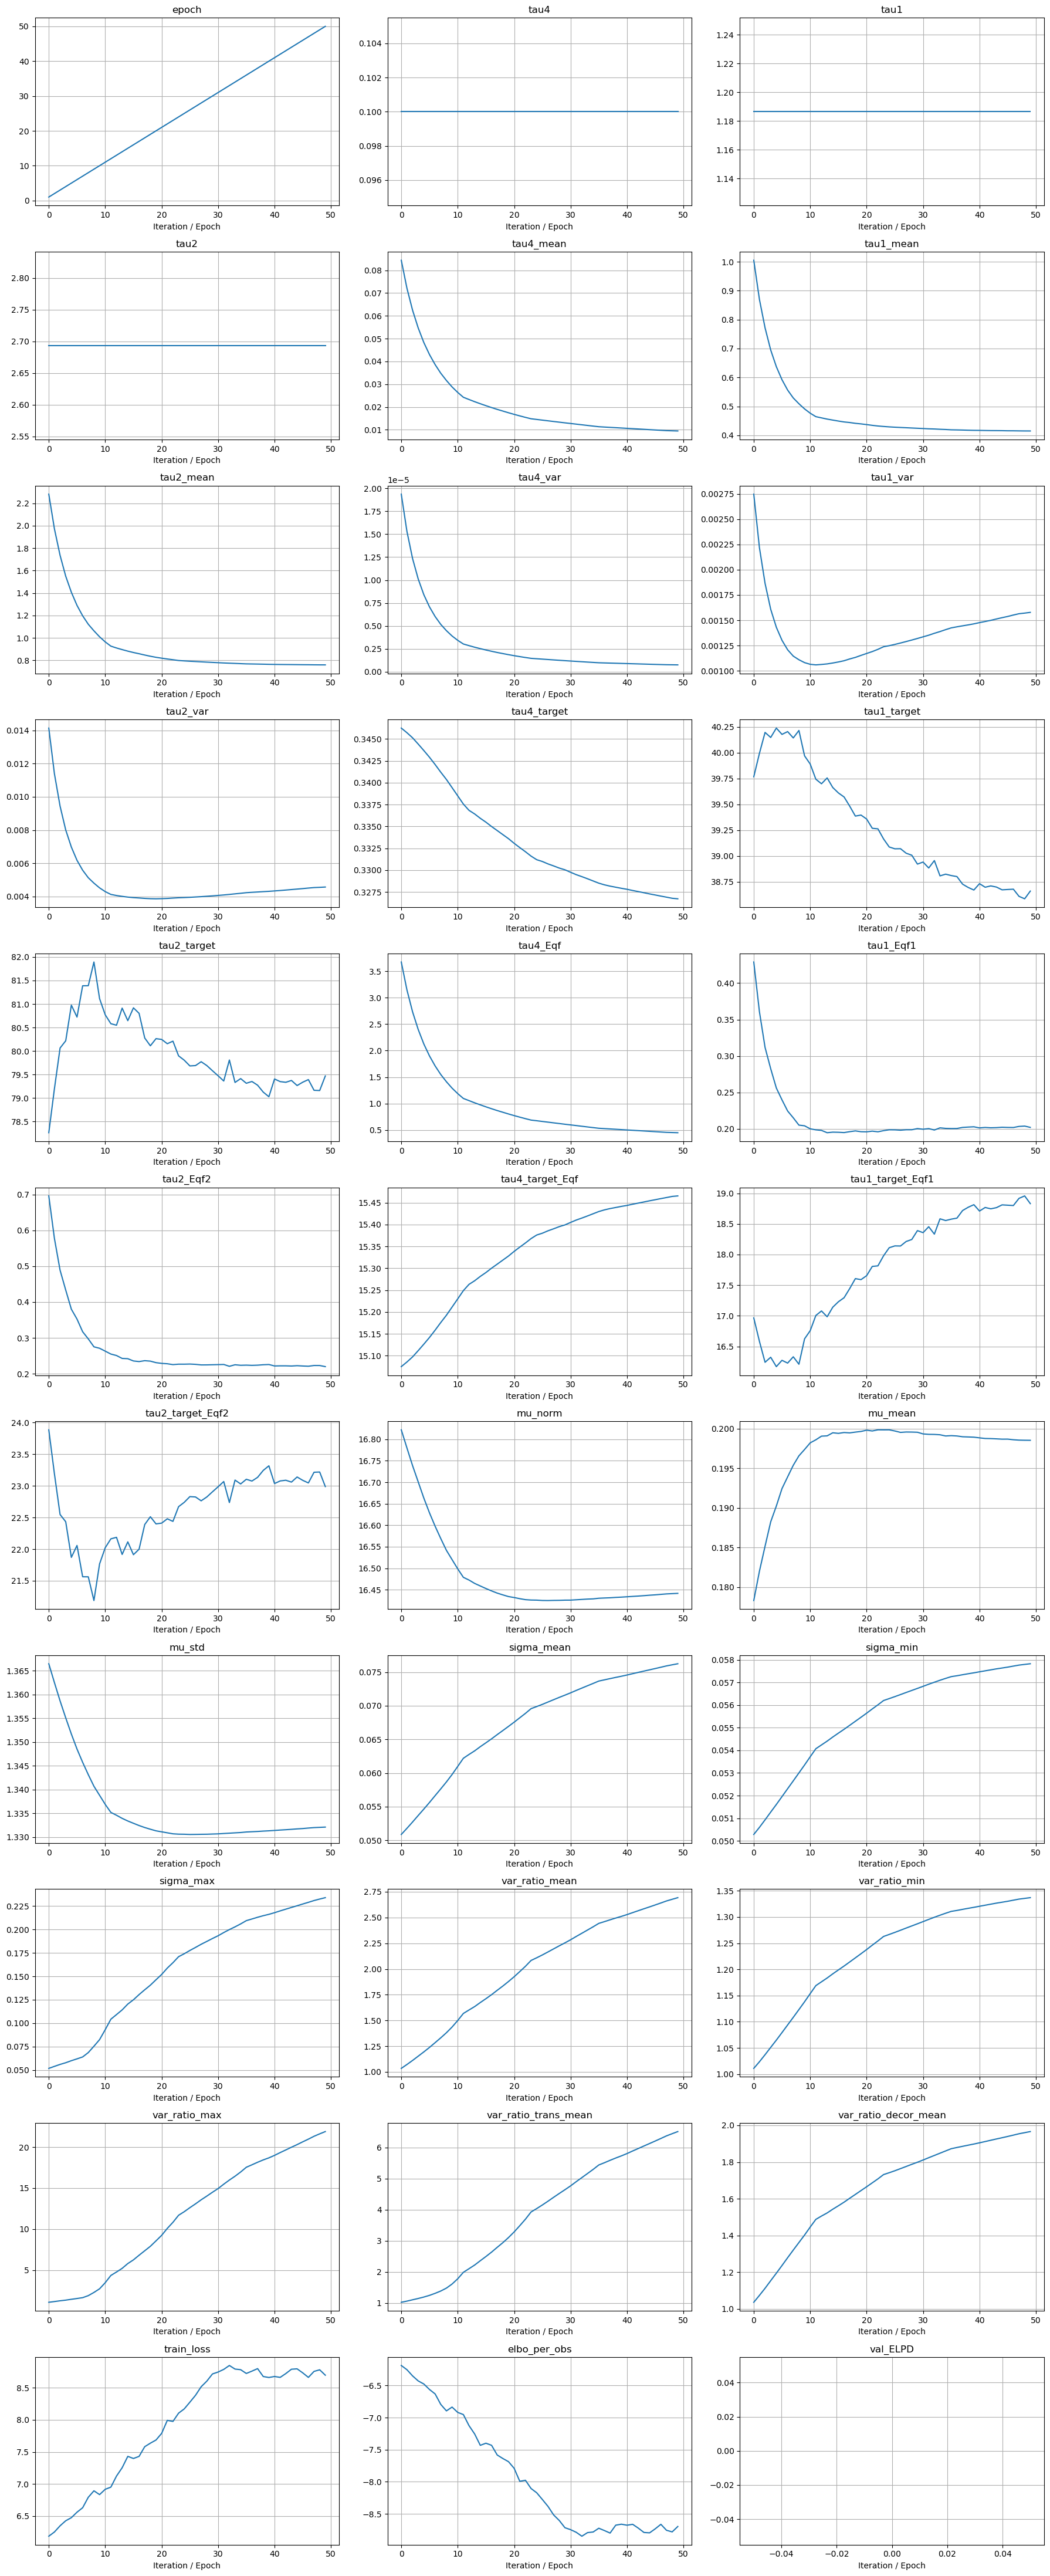

In [11]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



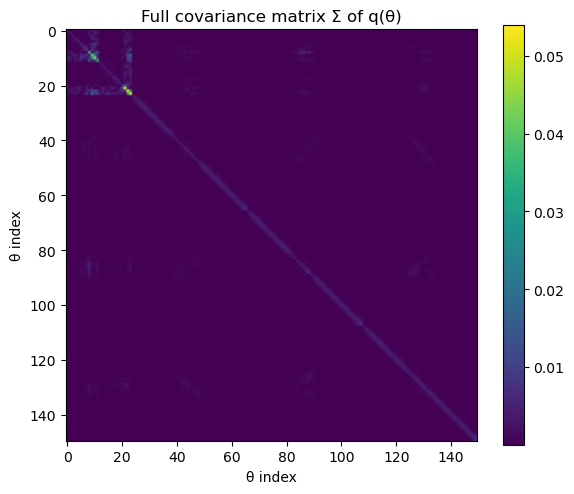

In [13]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


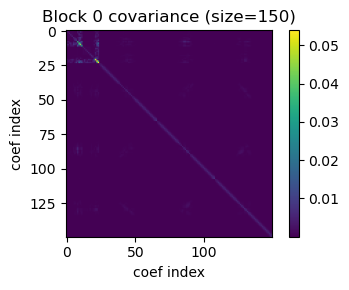

In [14]:
def plot_blocks_covariance(VI):
    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [15]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [17]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0063
KLD GTM      Train Data:  0.0098
KLD Gaussian Train Data:  0.1095
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.0133
KLD GTM      Test  Data:  0.0123
KLD Gaussian Test  Data:  0.112
KLD Copula   Test  Data:  0.0003


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = VI.predictive_sample(
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    n_samples=10_000,
    S=32,
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


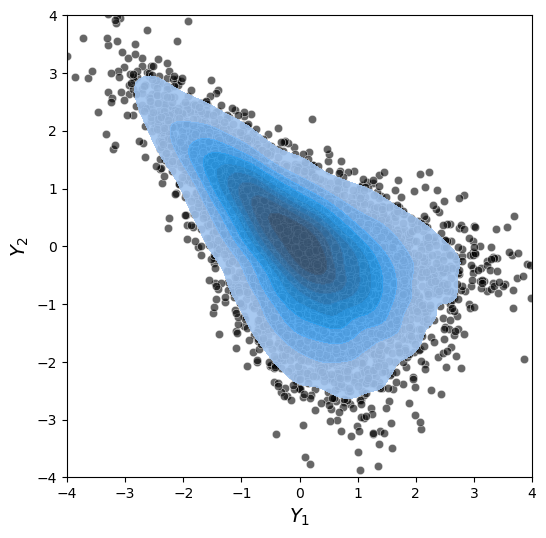

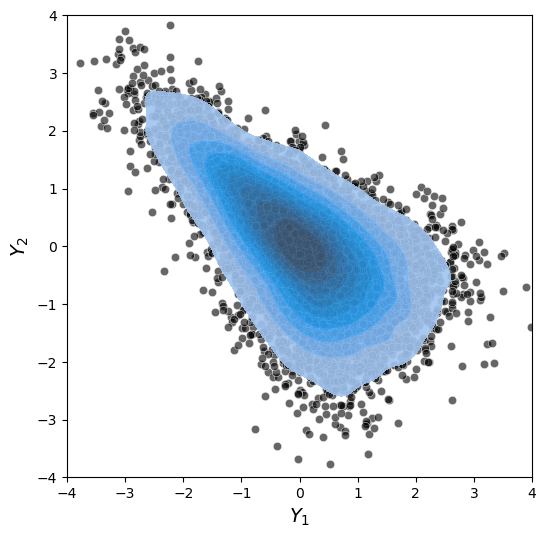

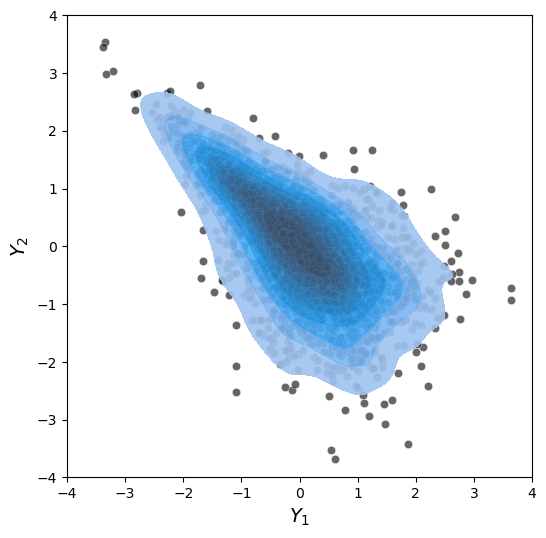

In [19]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

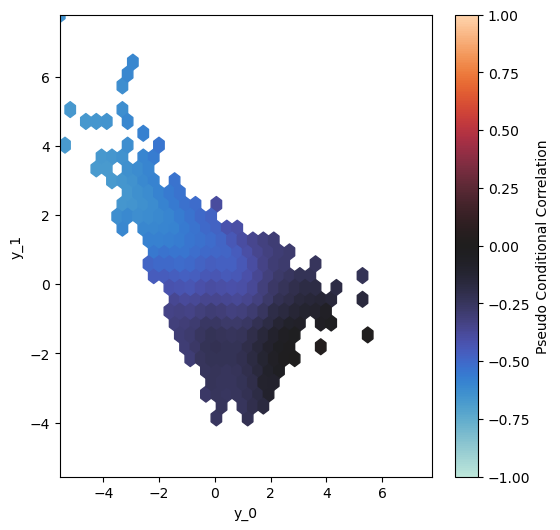

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


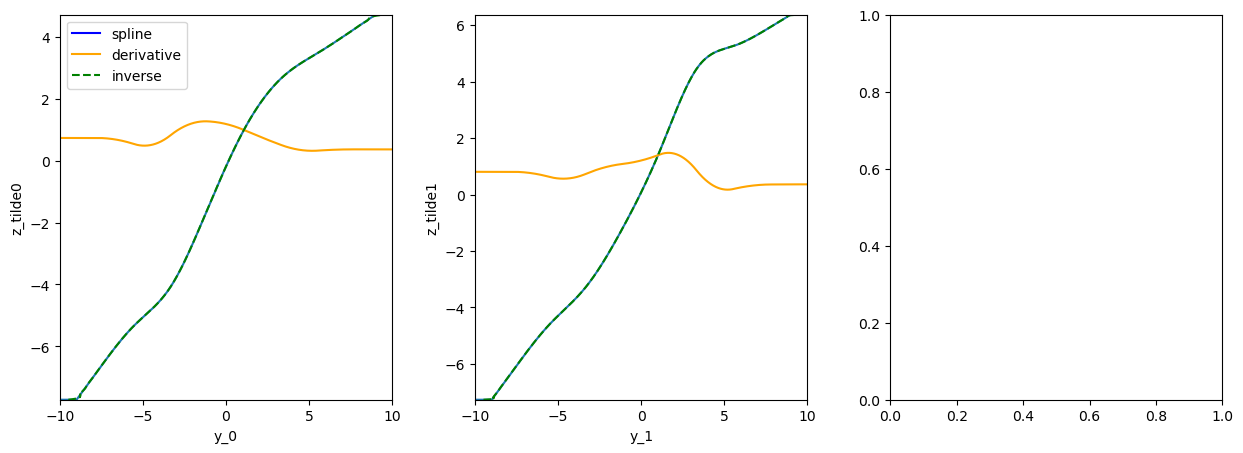

In [22]:
model.plot_splines(layer_type="transformation")

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


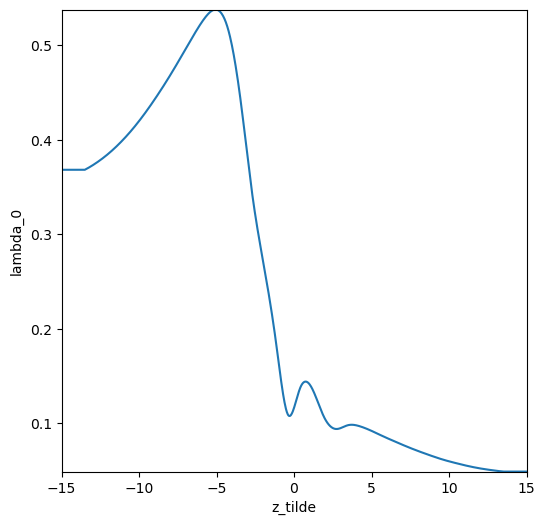

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


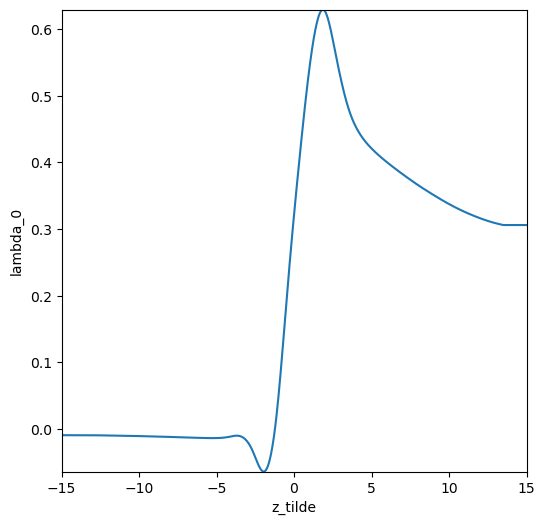

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


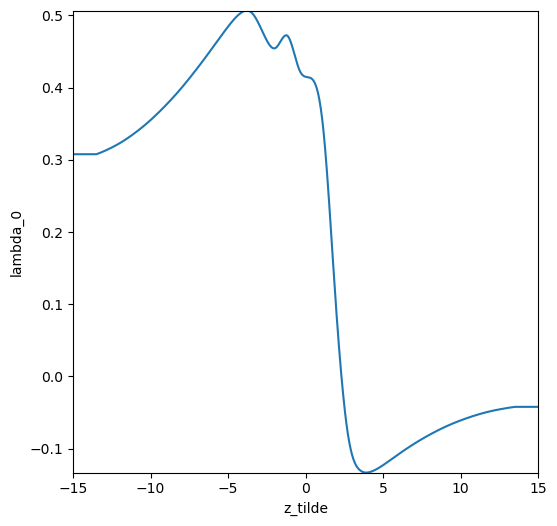

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)